In [1]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import scipy

import warnings

from Standard_functions import plot_features, get_user_split_data, plot_fit_score_pred

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
os.chdir('../Data/')

In [3]:
os.listdir()

['mini_feature_df',
 'mini_df',
 'products.csv',
 'orders.csv',
 '.DS_Store',
 '00_merged_prod_order',
 'mini_ord_prod_train_df',
 'order_products__train.csv',
 'departments.csv',
 'aisles.csv',
 'mini_ord_df',
 'order_products__prior.csv',
 'sample_submission.csv']

## Loading our Datasets

In [4]:
df = pd.read_pickle('00_merged_prod_order')
ord_prod_train_df = pd.read_csv('order_products__prior.csv')
ord_prod_test_df = pd.read_csv('order_products__train.csv')
ord_df = pd.read_csv('orders.csv')
ord_prod_train_df = ord_prod_train_df.merge(ord_df, on='order_id')
ord_prod_test_df = ord_prod_test_df.merge(ord_df, on='order_id')

#### Making mini and pickling

``` python
rs = np.random.RandomState(101)

total_users = df['user_id'].unique()
small_df_users = rs.choice(total_users, 
               size=int(total_users.shape[0] * .005), 
               replace=False)

df = df[df['user_id'].isin(small_df_users)]
ord_prod_train_df = ord_prod_train_df[ord_prod_train_df.user_id.isin(small_df_users)]
ord_df = ord_df[ord_df.user_id.isin(small_df_users)]
pd.to_pickle(df,'mini_df')
pd.to_pickle(ord_prod_train_df,'mini_ord_prod_train_df')
pd.to_pickle(ord_df,'mini_ord_df')
```

df = pd.read_pickle('mini_df')
ord_prod_train_df = pd.read_pickle('mini_ord_prod_train_df')
ord_df = pd.read_pickle('mini_ord_df')

In [5]:
df.user_id.nunique()

131209

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 5 columns):
product_id                   int64
user_id                      int64
num_ord_per_user_per_prod    int64
latest_cart                  object
in_cart                      int64
dtypes: int64(4), object(1)
memory usage: 387.9+ MB


## Feature Engineering

Our feature engineering began in the 'Organizing data section.  
We will visualize that first feature below and begin creating new features.

<Figure size 648x648 with 0 Axes>

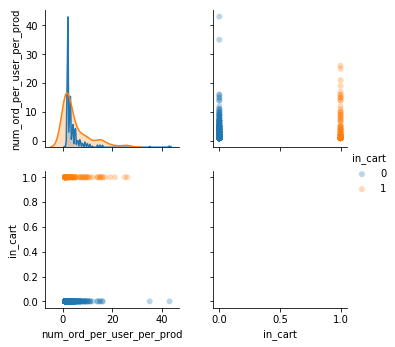

Our f1-score is 0.0864409013045197
The coefficients are: 
                     Features  Coefficients
0  num_ord_per_user_per_prod        0.1422
And we've predicted 1675585 non-re-orders and 16723 re-orders.


In [7]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

As you can see, we're setting the bar pretty low.

## Product Features
Note that product features are not user-specific.

### `product_total_orders`
Total number of orders placed for a given product.
### `product_avg_add_to_cart_order`
Average order in which a product was add to a users cart.

In [8]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (ord_prod_train_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df = df.merge(df_prod_features, on='product_id')

`product_total_orders` had some pretty enourmous rightward skew that ultimately resulted in the model producing 0 positive predictions. As a result I took the log base 2 transformation to punish outliers.  
Note that I attempted a log base 10 transformation but log base 2 had better results.

In [9]:
df.product_total_orders = np.log2(df.product_total_orders)

<Figure size 648x648 with 0 Axes>

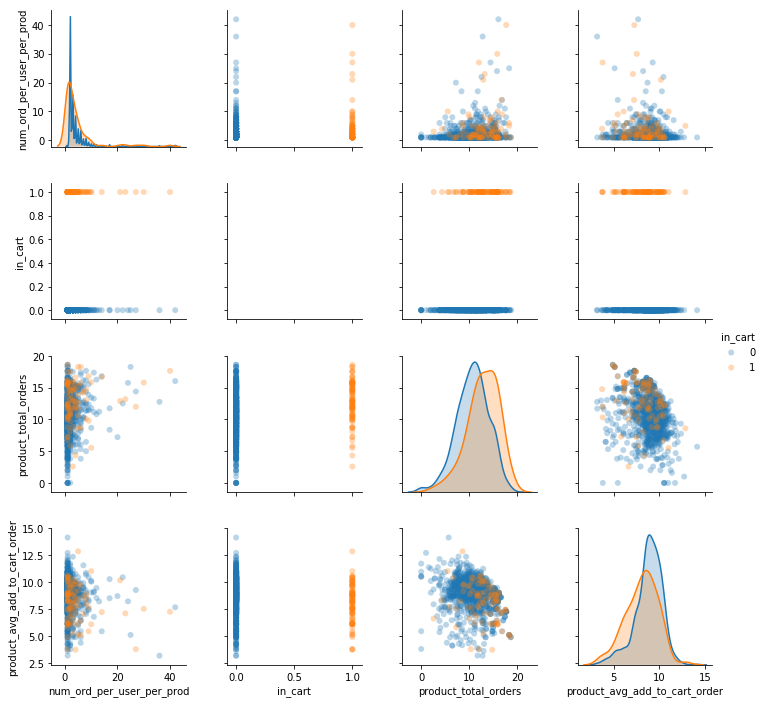

Our f1-score is 0.08748168842272651
The coefficients are: 
                         Features  Coefficients
0      num_ord_per_user_per_prod        0.1214
1           product_total_orders        0.0825
2  product_avg_add_to_cart_order       -0.1540
And we've predicted 1679360 non-re-orders and 16374 re-orders.


In [22]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User Features
`'user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'`

In [12]:
user_features = ['user_total_orders','user_avg_cartsize',
                 'user_total_products','user_avg_days_since_prior_order']

df_user_features = (ord_prod_train_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_id',
                         ['nunique', # user_total_orders
                        (lambda x: x.shape[0] / x.nunique())]), # user_avg_cartsize
                        ('product_id','nunique'), # user_total_products
                        ('days_since_prior_order','mean')]))) # user_avg_days_since_prior_order
df_user_features.columns = ['user_id'] + user_features
df = df.merge(df_user_features, on='user_id')

<Figure size 648x648 with 0 Axes>

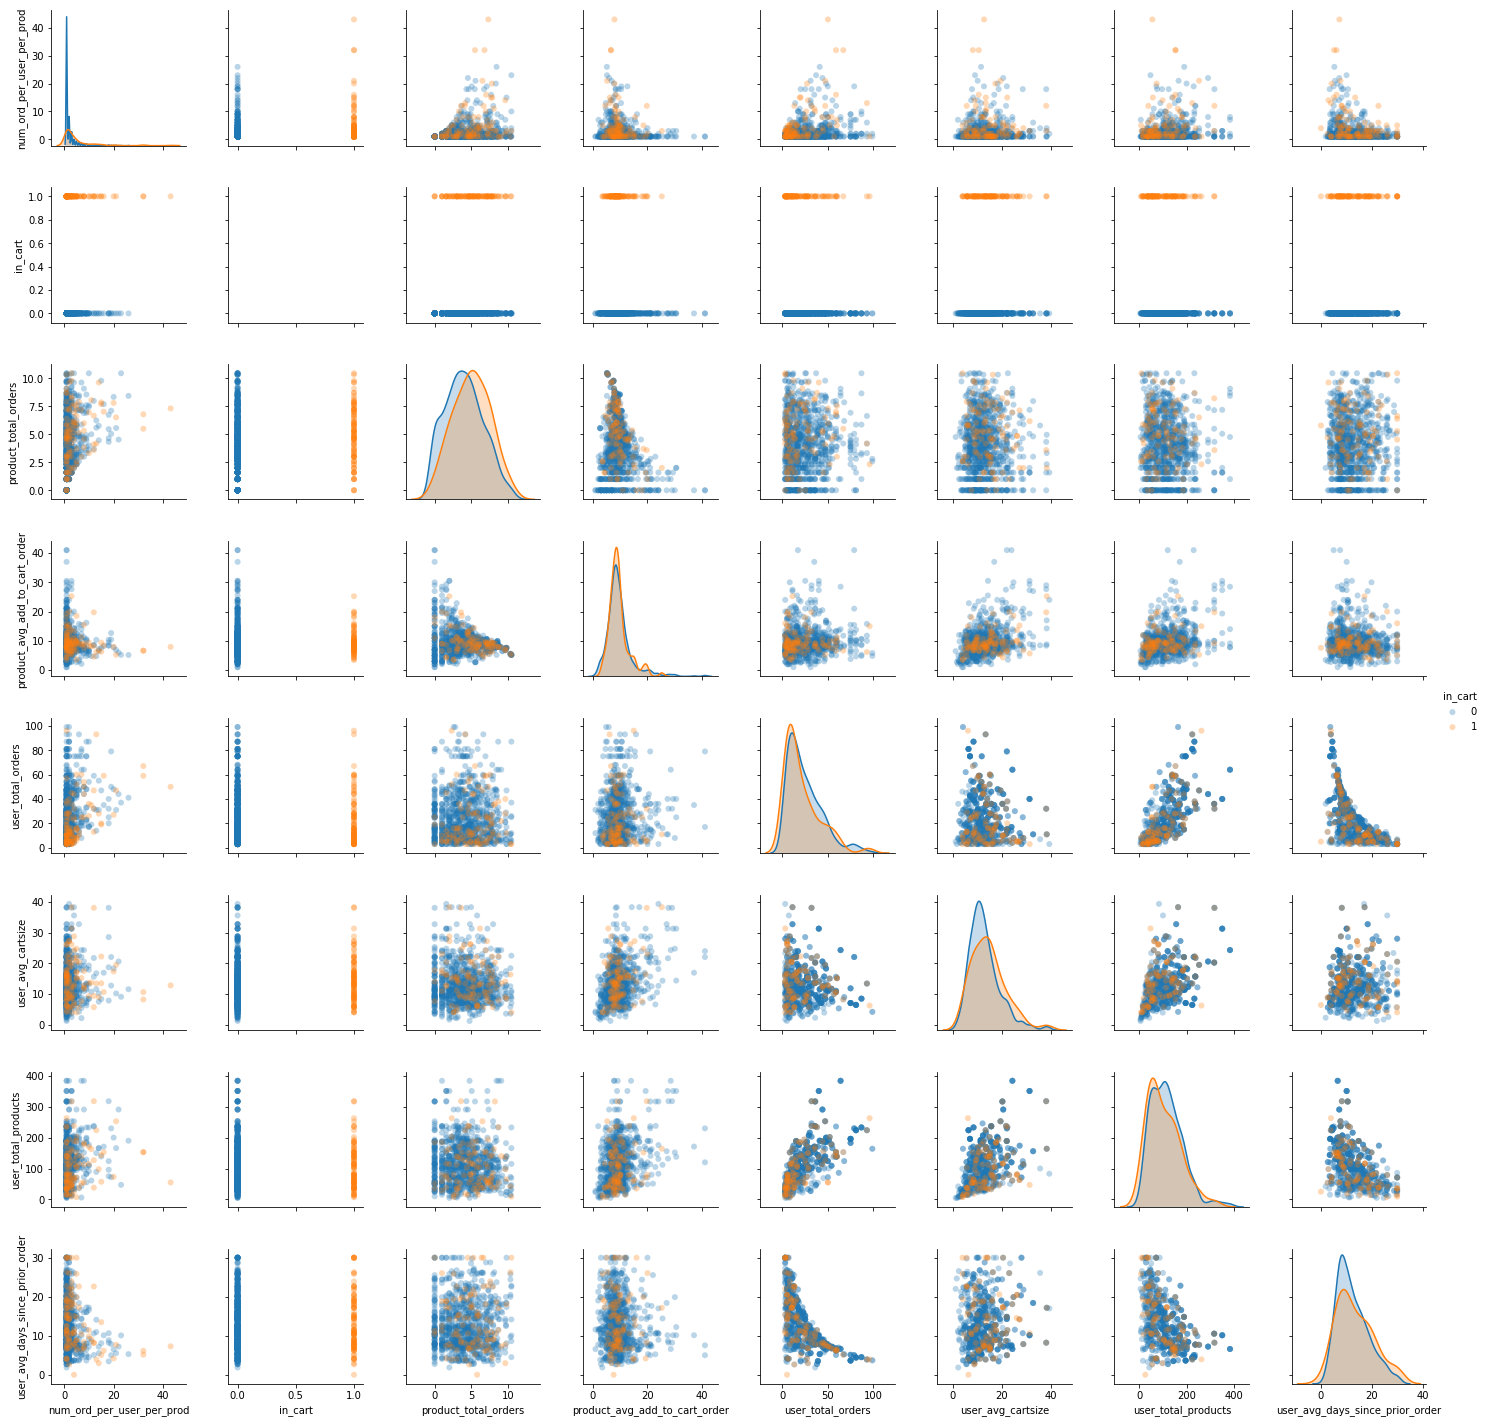

Our f1-score is 0.14049586776859502
The coefficients are: 
                           Features  Coefficients
0        num_ord_per_user_per_prod        0.1939
1             product_total_orders        0.0900
2    product_avg_add_to_cart_order       -0.0260
3                user_total_orders       -0.0220
4                user_avg_cartsize        0.0479
5              user_total_products       -0.0055
6  user_avg_days_since_prior_order        0.0009
And we've predicted 9128 non-re-orders and 124 re-orders.


In [13]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User-Product features

In [14]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (ord_prod_train_df.groupby(
                        ['product_id','user_id'],as_index=False) \
                        .agg(OrderedDict(
                        [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df = df.merge(df_user_prod_features,on=['user_id','product_id'])
df['user_product_order_freq'] = df['num_ord_per_user_per_prod'] / df['user_total_orders'] 

<Figure size 648x648 with 0 Axes>

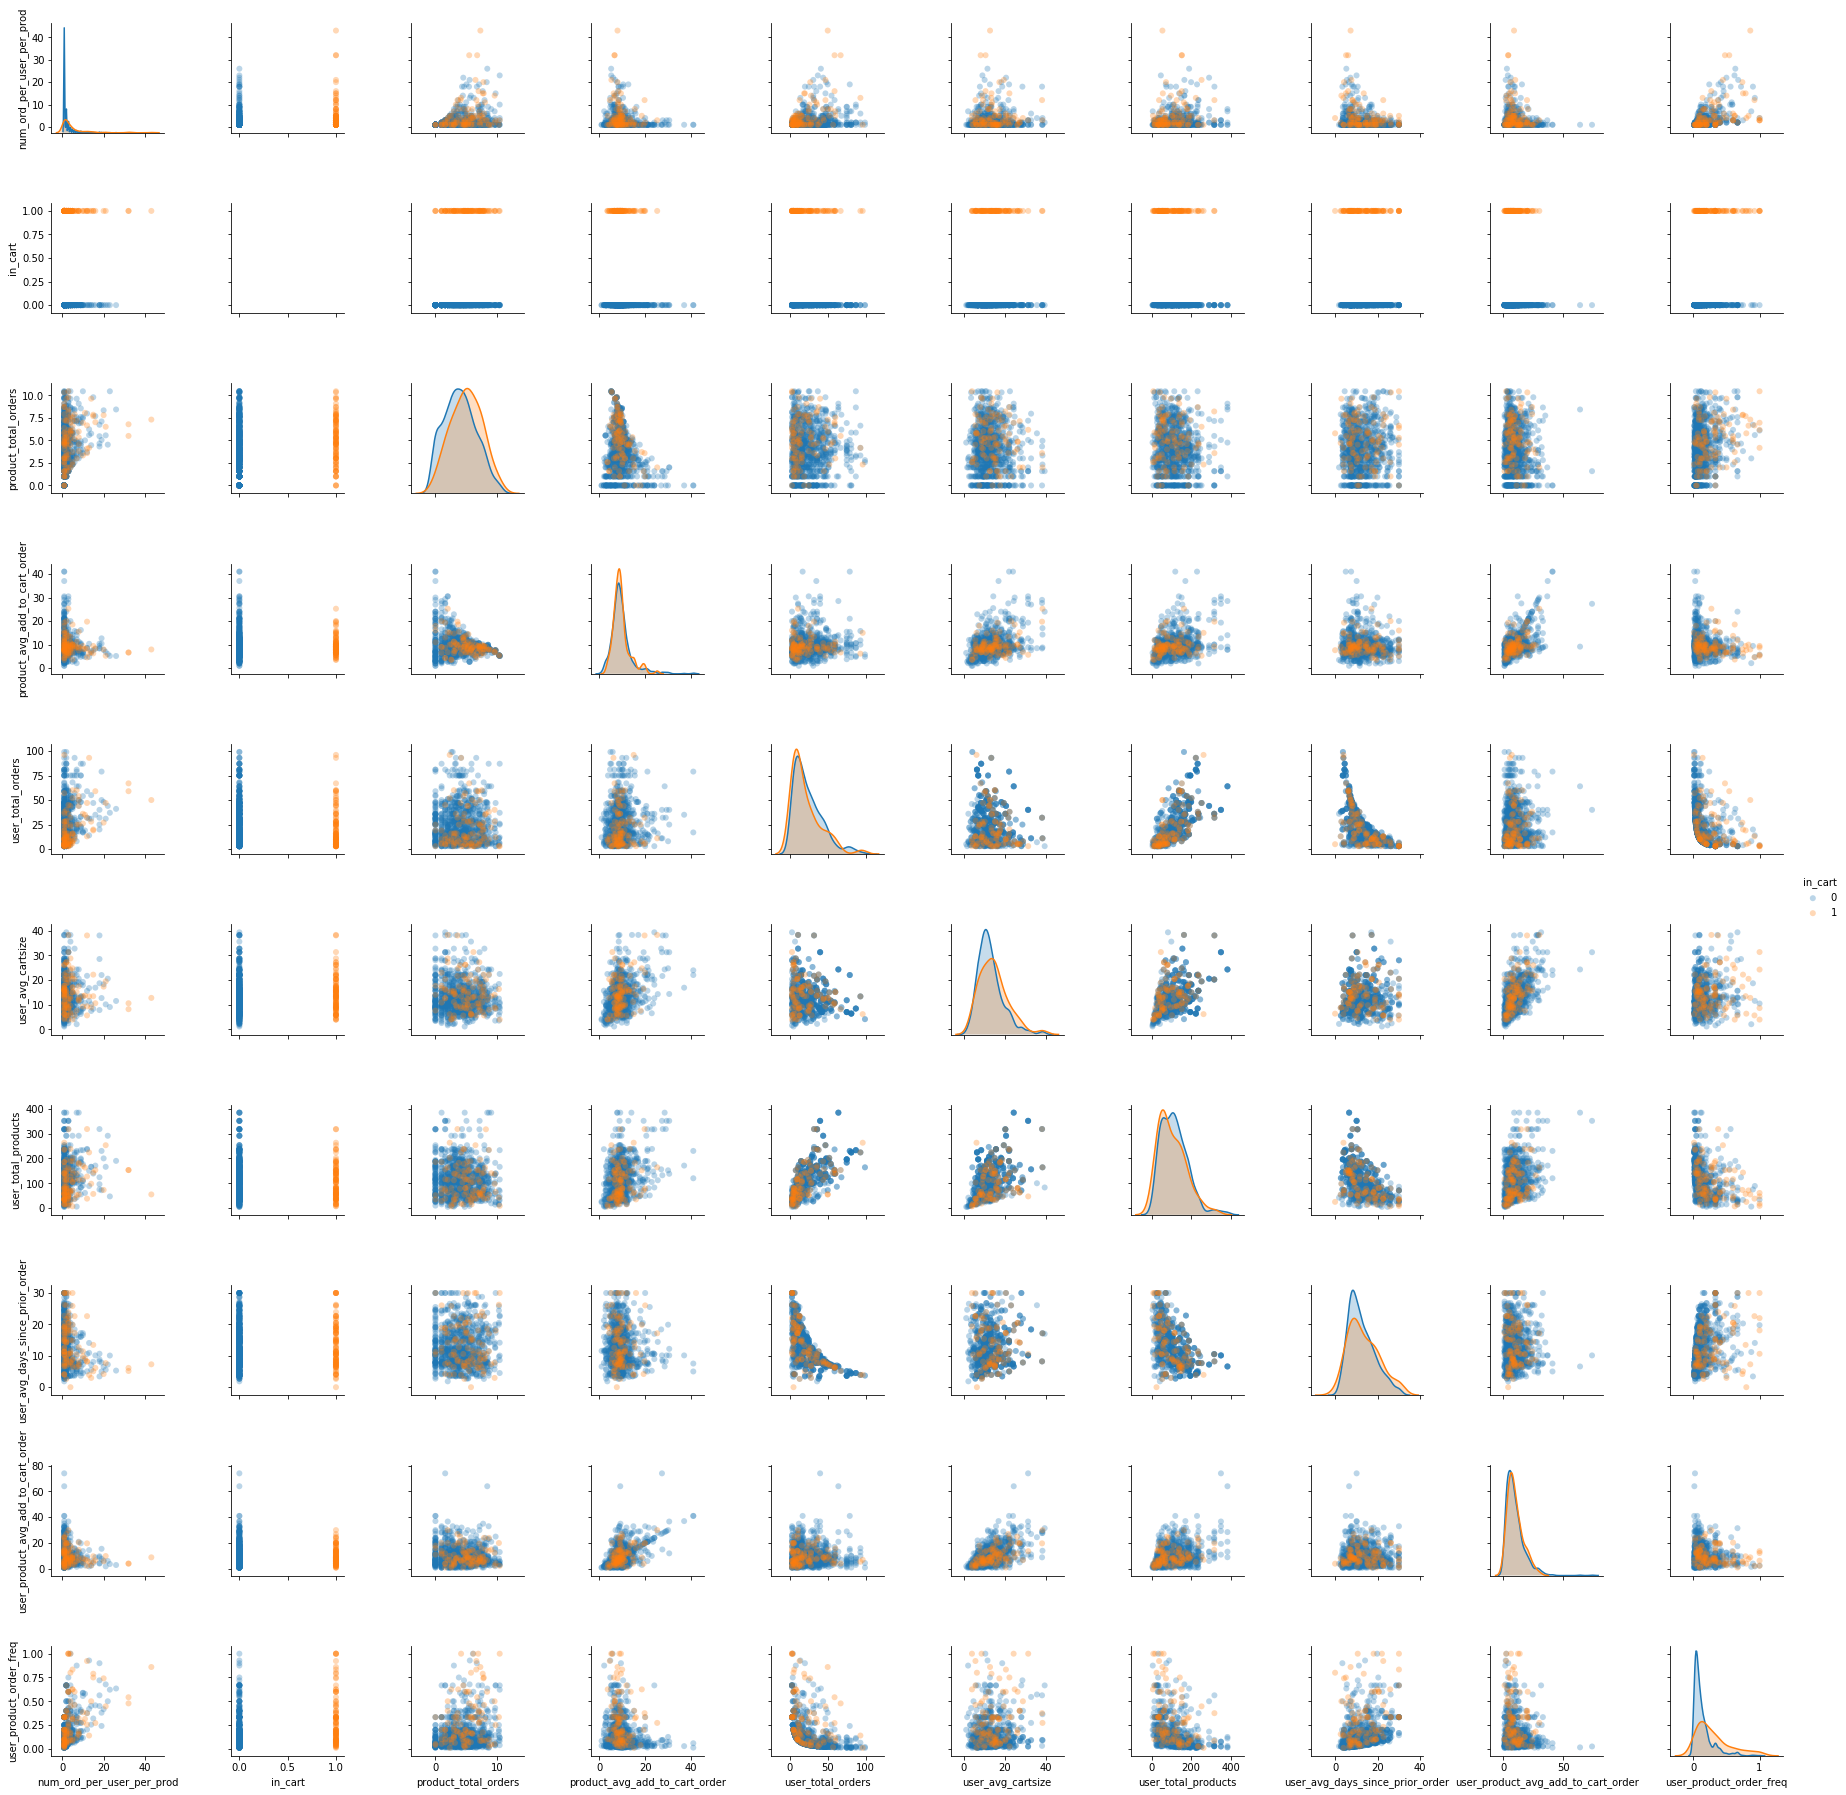

Our f1-score is 0.2202729044834308
The coefficients are: 
                              Features  Coefficients
0           num_ord_per_user_per_prod        0.0812
1                product_total_orders        0.0788
2       product_avg_add_to_cart_order       -0.0161
3                   user_total_orders       -0.0054
4                   user_avg_cartsize        0.0244
5                 user_total_products       -0.0023
6     user_avg_days_since_prior_order       -0.0063
7  user_product_avg_add_to_cart_order        0.0044
8             user_product_order_freq        3.2528
And we've predicted 9070 non-re-orders and 182 re-orders.


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [15]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Users Orders Features
mean, min, and max of order hour of day by user all proved to be poor predictors.

``` python
orders_features = ['mean_order_hour_of_day_by_user','min_order_hour_of_day_by_user',
                 'max_order_hour_of_day_by_user']

df_orders_features = (ord_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_hour_of_day',
                         ['mean', 'min', 'max'])]))) # user_avg_days_since_prior_order
df_orders_features.columns = ['user_id'] + orders_features
df = df.merge(df_orders_features, on='user_id')
```

Further grouping of the above by product provided no additional insight.

``` python 
avg_order_hour_by_user_by_product = (ord_prod_train_df
                             .dropna().groupby(['user_id','product_id']
                                ,as_index=False).order_hour_of_day.mean())

avg_order_hour_by_user_by_product.columns = ['user_id','product_id','avg_order_hour_by_user_by_product'] 
df = pd.merge(df, avg_order_hour_by_user_by_product,on=['user_id','product_id'])
```

## Count of Orders by Day of Week

``` python 
dummies = pd.get_dummies(ord_df.order_dow)
df_dummies = pd.merge(ord_df,dummies,how='outer',left_index=True,right_index=True)
total_orders_by_dow = (df_dummies.groupby('user_id',as_index=False)
                  .sum().drop(['order_number','order_dow','order_hour_of_day',
                              'days_since_prior_order'],axis=1))
total_orders_by_dow.columns = (['user_id','order_id'] + 
                    ['total_orders_day ' + str(x) for x in range(0,7)])
df = pd.merge(df, total_orders_by_dow,on=['user_id'])
```

## Mode Hour and DOW Ordered

``` python
product_mode_hour_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_hour_of_day
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_hour_ordered.columns = ['product_id','product_mode_hour_ordered']
df = pd.merge(df, product_mode_hour_ordered,on=['product_id'])
```

``` python 
product_mode_dow_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_dow
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_dow_ordered.columns = ['product_id','product_mode_dow_ordered']
df = pd.merge(df, product_mode_dow_ordered,on=['product_id'])
```

In [50]:
prod_features = ['product_total_reorders_2']

df_prod_features = (ord_prod_train_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('reordered','sum')])))
#df_prod_features.columns = ['product_id'] + prod_features
#df = df.merge(df_prod_features, on='product_id')

In [18]:
pd.to_pickle(df,'mini_feature_df')

In [29]:
ord_prod_train_df[ord_prod_train_df.user_id==202279]

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
5,2,17794,6,1,202279,prior,3,5,9,8.0
6,2,40141,7,1,202279,prior,3,5,9,8.0
7,2,1819,8,1,202279,prior,3,5,9,8.0
8,2,43668,9,0,202279,prior,3,5,9,8.0
990780,104690,1003,1,1,202279,prior,8,6,10,30.0


find the last time each product was ordered by a user  
and find the sum of all days since then that it wasn't ordered.

returning most recent time each item was ordered.

sum of days since prior order for each product where order_num is greater for  
that product that in most_recent_order_by_user_by_product

In [55]:
most_recent_order_by_user_by_product = ord_prod_train_df.groupby(['user_id','product_id'],
                                                        as_index=False).order_number.max()
most_recent_order_by_user_by_product.columns = (['user_id','product_id'] + 
                                                ['most_recent_order_by_user_by_product'])
max_orders_per_user = ord_prod_train_df.groupby(['user_id'],as_index=False).order_number.max()
max_orders_per_user.columns = ['user_id'] + ['number_orders_since_product_last_ordered']

In [57]:
max_orders_per_user = ord_prod_train_df.groupby(['user_id'],as_index=False).order_number.max()
max_orders_per_user.columns = ['user_id'] + ['number_orders_since_product_last_ordered']

In [58]:
number_orders_since_product_last_ordered = pd.merge(most_recent_order_by_user_by_product, 
                                                    max_orders_per_user,on='user_id')

In [67]:
number_orders_since_product_last_ordered = (number_orders_since_product_last_ordered[
                    ['most_recent_order_by_user_by_product','max_orders_per_user']]
                    .diff(axis=1).drop('most_recent_order_by_user_by_product',axis=1))

In [68]:
most_recent_order_by_user_by_product.drop('most_recent_order_by_user_by_product',
                                          axis=1,inplace=True) # we're just using this to get back our product_id and user_id

In [71]:
number_orders_since_product_last_ordered = pd.merge(number_orders_since_product_last_ordered,most_recent_order_by_user_by_product,
                        left_index=True,right_index=True)

In [72]:
df = pd.merge(df, number_orders_since_product_last_ordered,on=['user_id','product_id'])

<Figure size 648x648 with 0 Axes>

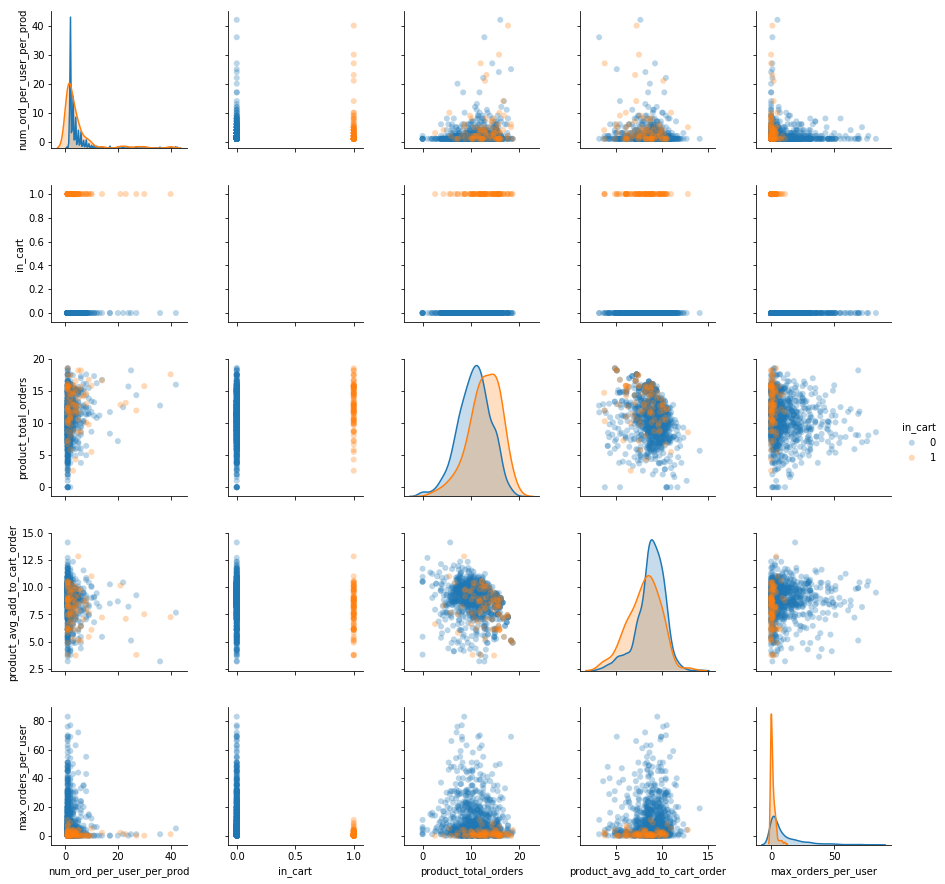

Our f1-score is 0.10983723033199844
The coefficients are: 
                         Features  Coefficients
0      num_ord_per_user_per_prod        0.0991
1           product_total_orders        0.0691
2  product_avg_add_to_cart_order       -0.1207
3            max_orders_per_user       -0.1641
And we've predicted 1677203 non-re-orders and 18531 re-orders.


In [73]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)